In [1]:
import numpy as np
import tensorflow as tf
from watermark import watermarking
from train import training
from evaluate import *
import sklearn.metrics as sk
import matplotlib.pyplot as plt
%matplotlib inline


dataset="cifar10"

forgery_directory="./data/forgery/"+dataset
saved_model_path="./load_model/classifier/"+dataset

if dataset=="cifar10":
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
elif dataset=="cifar100":
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

test_x=test_images / 255.
test_y=test_labels.reshape(-1)

forgery = tf.keras.preprocessing.image_dataset_from_directory(forgery_directory,
                                                              batch_size=10000,
                                                              image_size=(32, 32))
forgery=list(forgery.as_numpy_iterator())[0]
forgery_x=forgery[0].astype("uint8")
forgery_x=forgery_x / 255.
forgery_y=forgery[1]

Found 10000 files belonging to 10 classes.


In [2]:
# cifar10
base_model = tf.keras.models.load_model(saved_model_path+"/resnet_wm_0")
base2_model = tf.keras.models.load_model(saved_model_path+"/resnet_wm_0_OE")
wm_model = tf.keras.models.load_model(saved_model_path+"/resnet_wm_200")
wm2_model = tf.keras.models.load_model(saved_model_path+"/resnet_wm_200_OE")
gn_model = tf.keras.models.load_model(saved_model_path+"/resnet_gn_0.01")
gn2_model = tf.keras.models.load_model(saved_model_path+"/resnet_gn_0.01_OE")
sp_model = tf.keras.models.load_model(saved_model_path+"/resnet_sp_0.05")
sp2_model = tf.keras.models.load_model(saved_model_path+"/resnet_sp_0.05_OE")

## cifar100
# wm_model = tf.keras.models.load_model(saved_model_path+"/resnet_wm_500")
# wm2_model = tf.keras.models.load_model(saved_model_path+"/resnet_wm_500_OE")
# gn_model = tf.keras.models.load_model(saved_model_path+"/resnet_gn_0.01")
# gn2_model = tf.keras.models.load_model(saved_model_path+"/resnet_gn_0.01_OE")
# sp_model = tf.keras.models.load_model(saved_model_path+"/densenet_sp_0.05")
# sp2_model = tf.keras.models.load_model(saved_model_path+"/densenet_sp_0.05_OE")


base_prob_in_f, base_prob_out_f, base2_prob_in_f, base2_prob_out_f =\
    in_out_distinction(base_model, base2_model, test_x, forgery_x)

wm_prob_in_f, wm_prob_out_f, wm2_prob_in_f, wm2_prob_out_f =\
    in_out_distinction(wm_model, wm2_model, test_x, forgery_x)

gn_prob_in_f, gn_prob_out_f, gn2_prob_in_f, gn2_prob_out_f =\
    in_out_distinction(gn_model, gn2_model, test_x, forgery_x)

sp_prob_in_f, sp_prob_out_f, sp2_prob_in_f, sp2_prob_out_f =\
    in_out_distinction(sp_model, sp2_model, test_x, forgery_x)


[In- and Out-of-Distribution Detection (MSP)]

In-dist max softmax distribution (mean, std):
0.9135545 0.15860125
Out-of-dist max softmax distribution(mean, std):
0.6746591 0.22525536

Normality Detection
Normality base rate (%): 50.0
Prediction Prob: Normality Detection
AUPR (%): 87.16
AUROC (%): 84.7

Abnormality Detection
Abnormality base rate (%): 50.0
Prediction Prob: Abnormality Detection
AUPR (%): 81.2
AUROC (%): 84.7

[In- and Out-of-Distribution Detection (OE)]

In-dist max softmax distribution (mean, std):
0.9117898 0.1597251
Out-of-dist max softmax distribution(mean, std):
0.6543782 0.2405942

Normality Detection
Normality base rate (%): 50.0
Prediction Prob: Normality Detection
AUPR (%): 87.17
AUROC (%): 85.01

Abnormality Detection
Abnormality base rate (%): 50.0
Prediction Prob: Abnormality Detection
AUPR (%): 82.58
AUROC (%): 85.01

[In- and Out-of-Distribution Detection (MSP)]

In-dist max softmax distribution (mean, std):
0.9158538 0.15647636
Out-of-dist max softmax d

In [3]:
def safe_risky_to_roc_curve(safe, risky, inverse=False):
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    if inverse:
        labels[safe.shape[0]:] += 1
    else:
        labels[:safe.shape[0]] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    aupr = round(100*sk.average_precision_score(labels, examples), 2)
    auroc = round(100*sk.roc_auc_score(labels, examples), 2)
    fpr, tpr, _ = sk.roc_curve(labels, examples)
    return fpr, tpr, aupr, auroc

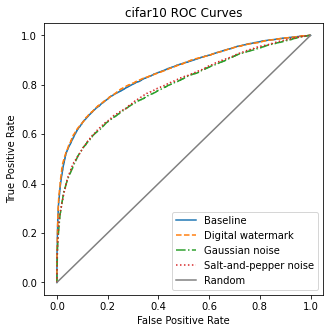

In [4]:
# ROC Curves
plt.figure(figsize=(5,5))
plt.title(dataset+' ROC Curves')

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(base_prob_in_f, base_prob_out_f)
plt.plot(fpr, tpr, '-',label="Baseline")

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(wm_prob_in_f, wm_prob_out_f)
plt.plot(fpr, tpr, '--', label="Digital watermark")

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(gn_prob_in_f, gn_prob_out_f)
plt.plot(fpr, tpr, '-.', label="Gaussian noise")

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(sp_prob_in_f, sp_prob_out_f)
plt.plot(fpr, tpr, ':', label="Salt-and-pepper noise")

plt.plot([0, 1], 'gray', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

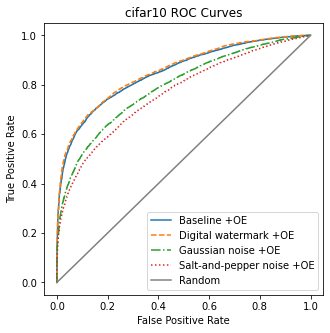

In [5]:
# ROC Curves OE
plt.figure(figsize=(5,5))
plt.title(dataset+' ROC Curves')

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(base2_prob_in_f, base2_prob_out_f)
plt.plot(fpr, tpr, '-', label="Baseline +OE")

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(wm2_prob_in_f, wm2_prob_out_f)
plt.plot(fpr, tpr, '--',label="Digital watermark +OE")

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(gn2_prob_in_f, gn2_prob_out_f)
plt.plot(fpr, tpr, '-.',label="Gaussian noise +OE")

fpr, tpr, aupr, auroc = safe_risky_to_roc_curve(sp2_prob_in_f, sp2_prob_out_f)
plt.plot(fpr, tpr, ':', label="Salt-and-pepper noise +OE")

plt.plot([0, 1], 'gray', label='Random')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [6]:
def safe_risky_to_pr_curve(safe, risky, inverse=False):
    labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
    if inverse:
        labels[safe.shape[0]:] += 1
    else:
        labels[:safe.shape[0]] += 1
    examples = np.squeeze(np.vstack((safe, risky)))
    aupr = round(100*sk.average_precision_score(labels, examples), 2)
    auroc = round(100*sk.roc_auc_score(labels, examples), 2)
    precision, recall, _ = sk.precision_recall_curve(labels, examples)
    return precision, recall, aupr, auroc

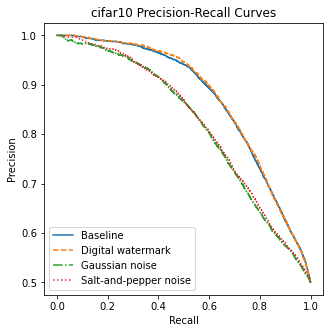

In [7]:
# Precision-Recall Curves
plt.figure(figsize=(5,5))
plt.title(dataset+' Precision-Recall Curves')

precision, recall, aupr, auroc = safe_risky_to_pr_curve(base_prob_in_f, base_prob_out_f)
plt.plot(recall, precision, '-',label="Baseline")

precision, recall, aupr, auroc = safe_risky_to_pr_curve(wm_prob_in_f, wm_prob_out_f)
plt.plot(recall, precision, '--', label="Digital watermark")

precision, recall, aupr, auroc = safe_risky_to_pr_curve(gn_prob_in_f, gn_prob_out_f)
plt.plot(recall, precision, '-.', label="Gaussian noise")

precision, recall, aupr, auroc = safe_risky_to_pr_curve(sp_prob_in_f, sp_prob_out_f)
plt.plot(recall, precision, ':', label="Salt-and-pepper noise")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

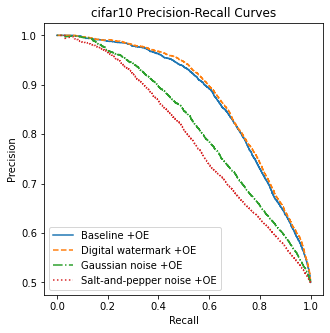

In [8]:
# Precision-Recall Curves OE
plt.figure(figsize=(5,5))
plt.title(dataset+' Precision-Recall Curves')

precision, recall, aupr, auroc = safe_risky_to_pr_curve(base2_prob_in_f, base2_prob_out_f)
plt.plot(recall, precision, '-', label="Baseline +OE")

precision, recall, aupr, auroc = safe_risky_to_pr_curve(wm2_prob_in_f, wm2_prob_out_f)
plt.plot(recall, precision, '--',label="Digital watermark +OE")

precision, recall, aupr, auroc = safe_risky_to_pr_curve(gn2_prob_in_f, gn2_prob_out_f)
plt.plot(recall, precision, '-.',label="Gaussian noise +OE")

precision, recall, aupr, auroc = safe_risky_to_pr_curve(sp2_prob_in_f, sp2_prob_out_f)
plt.plot(recall, precision, ':', label="Salt-and-pepper noise +OE")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()